# 3.1 Batch mode training using least squares - supervised learning of network weights

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
from matplotlib.patches import Circle, Ellipse
from scipy.stats import multivariate_normal
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D

## 3. Assignment - Part I

### 3.1. Batch mode training using least squares - supervised learning of network weights

#### Setup

Define the data:

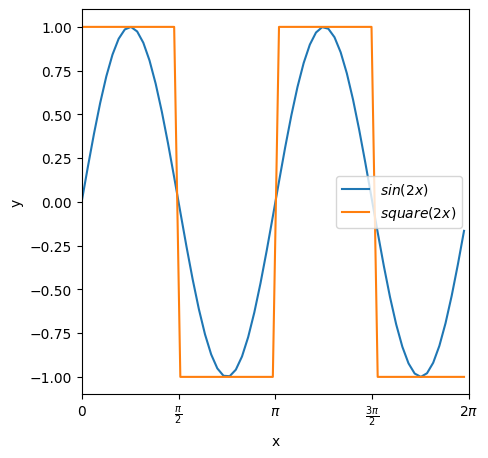

In [2]:
def functions(x, noise_variance=None):
    """Generate sin and square wave functions with optional noise.
    
    Args:
        x (ndarray): Input values
        noise_variance (float, optional): Variance of Gaussian noise to add
    
    Returns:
        tuple: (sin wave, square wave) arrays
    """
    # Generate base signals
    y_sin = np.sin(2*x)
    y_square = np.sign(y_sin)
    y_square[y_square==0] = 1
    
    # Add noise if specified
    if noise_variance is not None:
        std = np.sqrt(noise_variance)
        noise = np.random.normal(scale=std, size=y_sin.shape)
        y_sin += noise
        y_square += noise
        
    return y_sin, y_square

# Generate input data
x = np.arange(0, 2*np.pi, 0.1)[:, np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:, np.newaxis]

# Generate clean training and test data
y_sin, y_square = functions(x)
y_sin_test, y_square_test = functions(x_test)

# Visualization settings
plt.figure(figsize=(5, 5))
plt.plot(x, y_sin, label="$sin(2x)$")
plt.plot(x, y_square, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0, 2*np.pi])

# Configure x-axis ticks with mathematical notation
x_ticks = np.arange(0, 5/2*np.pi, np.pi/2)
x_labels = ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
plt.xticks(x_ticks, x_labels)
plt.legend()

Define the class for training Gaussian Radial Basis Functions.

In [61]:
DEFAULT_NODES = 10
DEFAULT_NODE_POS = 'equal'
DEFAULT_NODE_STD = 1
DEFAULT_CL_SYMMETRICAL = False
DEFAULT_CL_RANDOM_START = True
DEFAULT_CL_LEARNING_RATE = 0.2
DEFAULT_CL_EPOCHS = 100
DEFAULT_CL_BIAS = False
DEFAULT_CL_BIAS_WEIGHT = 0.01
DEFAULT_CL_VERBOSE = False
DEFAULT_LEARNING_RATE_DELTA = 0.1
DEFAULT_EPOCHS_DELTA = 100
DEFAULT_SHUFFLE_DELTA = False
DEFAULT_POSTPROCESSING = None
DEFAULT_TRAINING = 'least_squares'
DEFAULT_RUNS = 10

class GaussianRBFNetwork:

    def __init__(self,
                 data,
                 nodes=DEFAULT_NODES,
                 node_pos=DEFAULT_NODE_POS,
                 node_std=DEFAULT_NODE_STD,
                 cl_symmetrical=DEFAULT_CL_SYMMETRICAL,
                 cl_random_start=DEFAULT_CL_RANDOM_START,
                 cl_learning_rate=DEFAULT_CL_LEARNING_RATE,
                 cl_epochs=DEFAULT_CL_EPOCHS,
                 cl_bias=DEFAULT_CL_BIAS,
                 cl_bias_weight=DEFAULT_CL_BIAS_WEIGHT,
                 cl_verbose=DEFAULT_CL_VERBOSE,
                 postprocessing=DEFAULT_POSTPROCESSING
                ):

        self.data = data
        self.nodes = nodes
        self.node_pos = node_pos
        self.postprocessing = postprocessing
        self.cl_learning_rate = cl_learning_rate
        self.cl_epochs = cl_epochs

        # Initialize node positions based on strategy
        self._initialize_nodes(node_std)
        
        # Initialize the weights that connect to the output layer
        self.weights = np.random.randn(self.nodes, 1)
        
    def _initialize_nodes(self, node_std):
        """Initialize node positions and covariances based on selected strategy."""
        if self.node_pos == 'cl':
            self._init_kernels_cl(std=node_std)
        if self.node_pos == 'cl_prevent_dead_units': 
            self._init_cl_prevent_dead_units(std=node_std)
        elif self.node_pos == 'random':
            self._init_random_nodes(node_std)
        elif self.node_pos == 'equal':
            self._init_equal_nodes(node_std)
        # Manual initialization handled by caller

    def _init_random_nodes(self, node_std):
        """Initialize nodes with random positions."""
        indices = np.random.randint(self.data.shape[0], size=self.nodes)
        self.mu = self.data[indices]
        self.cov = np.full(self.nodes, node_std**2)

    def _init_equal_nodes(self, node_std):
        """Initialize nodes with equal spacing."""
        self.mu = np.linspace(self.data[0], self.data[-1], self.nodes)
        self.cov = np.full(self.nodes, node_std**2)

    def _init_kernels_cl(self, std=1.0):
        """Initialize RBF node positions using Competitive Learning (CL)."""
        self.mu = np.random.uniform(np.min(self.data), np.max(self.data), size=self.nodes)
        learning_rate = self.cl_learning_rate

        for epoch in range(self.cl_epochs):
            sample = self.data[np.random.randint(0, len(self.data))]
            closest_idx = np.argmin(np.abs(self.mu - sample))
            self.mu[closest_idx] += learning_rate * (sample - self.mu[closest_idx])
            learning_rate *= 0.99 

        self.cov = np.full(self.nodes, std**2)

    def _init_cl_prevent_dead_units(self, std=1.0, neighborhood_size=2):
        """Initialize RBF node positions using Competitive Learning (CL) with multiple winners to avoid dead units."""
        self.mu = np.random.uniform(np.min(self.data), np.max(self.data), size=self.nodes)
        learning_rate = self.cl_learning_rate

        for epoch in range(self.cl_epochs):
            sample = self.data[np.random.randint(0, len(self.data))]
            distances = np.abs(self.mu - sample)            
            sorted_indices = np.argsort(distances)
            
            for i in range(min(neighborhood_size, self.nodes)):
                idx = sorted_indices[i]
                influence = np.exp(-i**2 / (2 * (neighborhood_size**2)))
                self.mu[idx] += learning_rate * influence * (sample - self.mu[idx])
            
            learning_rate *= 0.99

        self.cov = np.full(self.nodes, std**2)


    def _compute_phi_matrix(self, inputs):
        """Compute the RBF activation matrix for given inputs."""
        return np.array([[multivariate_normal.pdf(x, mean=self.mu[i], cov=self.cov[i]) 
                         for i in range(self.nodes)] for x in inputs])

        
    def least_squares_fit(self, inputs, outputs):
        """Fit network weights using least squares method."""
        phi = self._compute_phi_matrix(inputs)
        self.weights, _, _, _ = la.lstsq(phi, np.ravel(outputs), rcond=None)
        self.weights = self.weights[:, np.newaxis]

    def delta_rule_train(self,
                        inputs,
                        outputs,
                        learning_rate=DEFAULT_LEARNING_RATE_DELTA,
                        epochs=DEFAULT_EPOCHS_DELTA,
                        shuffle=DEFAULT_SHUFFLE_DELTA,
                        improve=False):
        """Train network weights using delta rule."""
        if not improve:
            self.weights = np.random.randn(self.nodes, 1)
            
        for _ in range(epochs):
            indices = np.random.permutation(len(inputs)) if shuffle else range(len(inputs))
            for idx in indices:
                sample, expected = inputs[idx], outputs[idx]
                phi = self._compute_phi_matrix([sample]).T
                err = expected - phi.T @ self.weights
                self.weights += learning_rate * err * phi

    def predict(self, inputs):
        """Make predictions for given inputs."""
        pred = self._compute_phi_matrix(inputs) @ self.weights
        
        if self.postprocessing is not None:
            pred = self.postprocessing(pred)
        
        return pred

#### 3.1.1. Try to vary the number of units

In [4]:
def profile_nodes_sigma(x, x_test, y, y_test, nodes_profile, nodes_preview, 
                       kwargs_network=None, kwargs_training=None, title=None):
    """
    Profile RBF network performance for different numbers of nodes and sigma values.
    
    Args:
        x: Training input data
        x_test: Test input data
        y: Training target data
        y_test: Test target data
        nodes_profile: Range of nodes to profile
        nodes_preview: List of nodes to preview
        kwargs_network: Network configuration parameters
        kwargs_training: Training configuration parameters
        title: Plot title
    """
    # Initialize default kwargs
    kwargs_network = kwargs_network or {}
    kwargs_training = kwargs_training or {}
    
    # Extract training parameters
    training = kwargs_training.pop('training', DEFAULT_TRAINING)
    node_std = kwargs_network.pop('node_std', DEFAULT_NODE_STD)

    def fit_model(nodes, sigma=DEFAULT_NODE_STD):
        """Create and train a RBF network model."""
        model = GaussianRBFNetwork(data=x, nodes=nodes, node_std=sigma, **kwargs_network)
        
        if training == 'least_squares':
            model.least_squares_fit(x, y)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y, **kwargs_training)
            
        return model
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(15, 7.5))
    
    # Preview subplot
    ax1 = fig.add_subplot(221)
    _plot_preview(ax1, x_test, y_test, nodes_preview, fit_model)
    
    # Profiling subplot
    ax2 = fig.add_subplot(222)
    _plot_profiling(ax2, nodes_profile, x_test, y_test, node_std, fit_model, title)

def _plot_preview(ax, x_test, y_test, nodes_preview, fit_model):
    """Plot preview of model predictions for different numbers of nodes."""
    ax.plot(x_test, y_test, color='black', linewidth=2, linestyle='--', label="Ground Truth")
    
    for nodes in nodes_preview:
        model = fit_model(nodes)
        predictions = model.predict(x_test)
        ax.plot(x_test, predictions, label=f"{nodes} units")
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(loc='lower left')

def _plot_profiling(ax, nodes_profile, x_test, y_test, node_std, fit_model, title):
    """Plot error analysis for different sigma values."""
    if title:
        ax.set_title(f"{title} - Error Analysis")
    
    # Convert node_std to list if it's a single value
    sigma_values = [node_std] if isinstance(node_std, (float, int)) else node_std
    
    for sigma in sigma_values:
        residuals = _calculate_residuals(nodes_profile, x_test, y_test, sigma, fit_model)
        ax.plot(nodes_profile, residuals, linestyle='--', 
                marker='o', label=f"sigma={sigma}")
    
    ax.legend(loc='lower left')
    ax.set_xlabel("Number of Units")
    ax.set_ylabel("Residual Error")
    
    # Add threshold lines
    for threshold in [0.1, 0.01, 0.001]:
        ax.axhline(threshold, color='r', linestyle='--')

def _calculate_residuals(nodes_profile, x_test, y_test, sigma, fit_model):
    """Calculate residual errors for each number of nodes."""
    residuals = []
    for nodes in nodes_profile:
        model = fit_model(nodes, sigma)
        predictions = model.predict(x_test)
        mean_abs_error = np.mean(np.abs(predictions - y_test.reshape(y_test.shape[0], 1)))
        residuals.append(mean_abs_error)
    return residuals

Results for Sin Function:

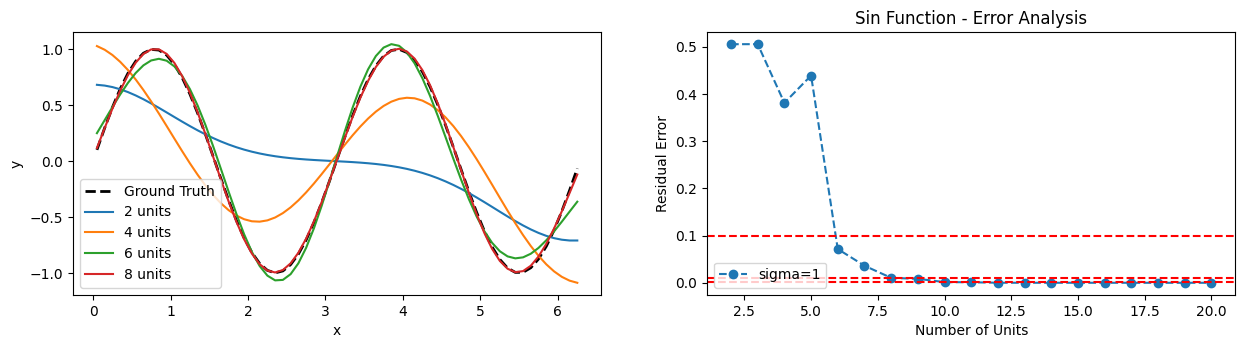

In [5]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 21), nodes_preview=[2,4,6,8], title="Sin Function")

Results for Square Function:

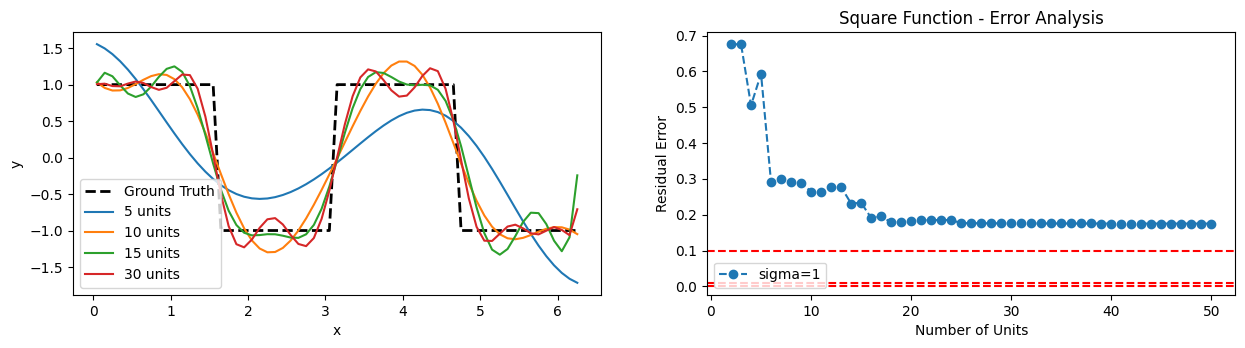

In [6]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 51), 
                    nodes_preview=[5,10,15,30], title="Square Function")

#### 3.1.2 Output transform for performance improvement

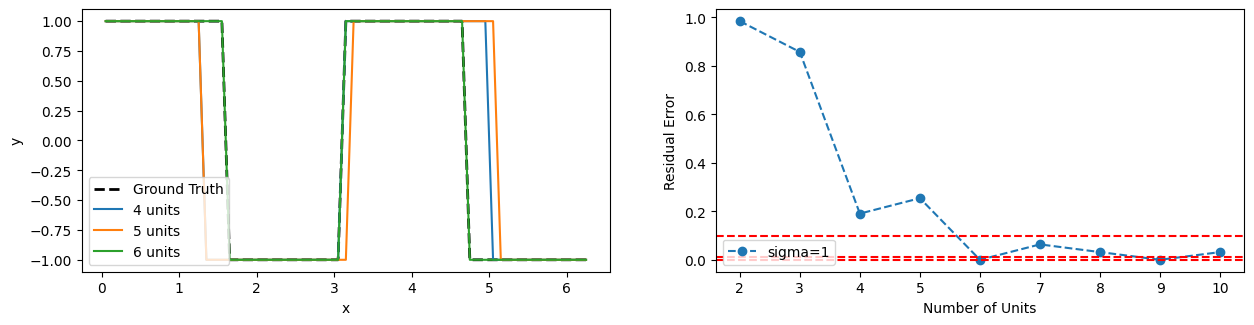

In [7]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 11), nodes_preview=[4,5,6],
                    kwargs_network={'postprocessing': lambda prediction: np.sign(prediction)})

### 3.2 Regression with noise

#### 3.2.1 Compare the effect of the number of RBF units and their width for the two learning approaches:

Define the data:

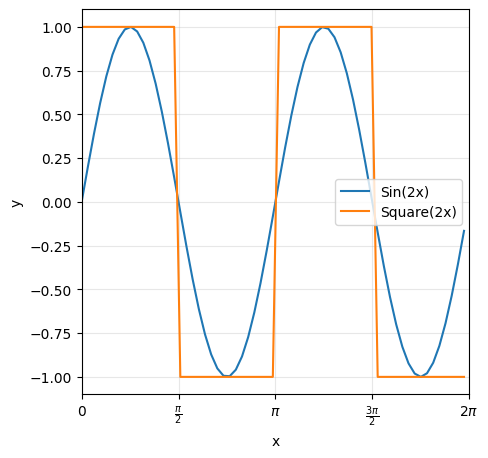

In [8]:
# Create noisy input functions with fixed random seed for reproducibility
np.random.seed(42)
y_noisy_sin, y_noisy_square = functions(x, noise_variance=0.1)
y_test_noisy_sin, y_test_noisy_square = functions(x_test, noise_variance=0.1)

# Plot configuration
plt.figure(figsize=(5, 5))

# Plot data
plt.plot(x, y_sin, label="Sin(2x)")
plt.plot(x, y_square, label="Square(2x)")  

# Configure axes
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 2*np.pi)

# Create x-axis ticks with mathematical notation
x_ticks = np.arange(0, 2.5*np.pi, np.pi/2)
x_labels = ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
plt.xticks(x_ticks, x_labels)

plt.legend()
plt.grid(True, alpha=0.3)

Compare the effect of the number of RBF units and their width for the two learning approaches:

Least squares:

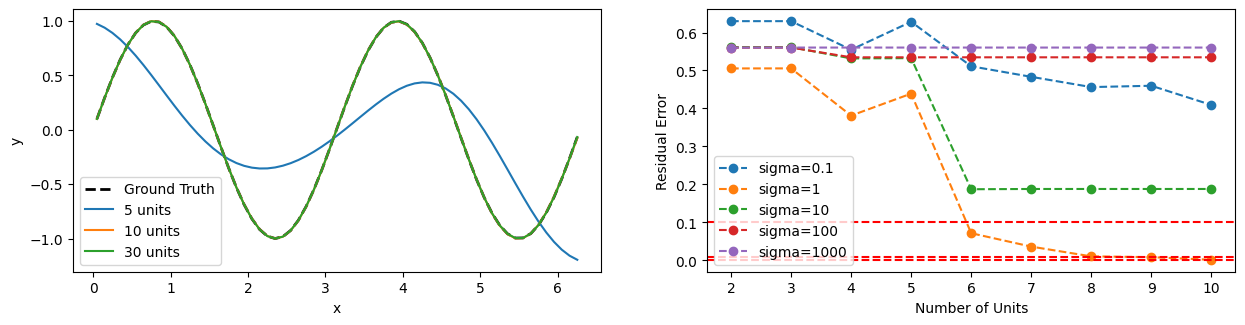

In [9]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': [0.1, 1, 10, 100, 1000]}, 
                    kwargs_training={'training': 'least_squares'})

Delta rule:

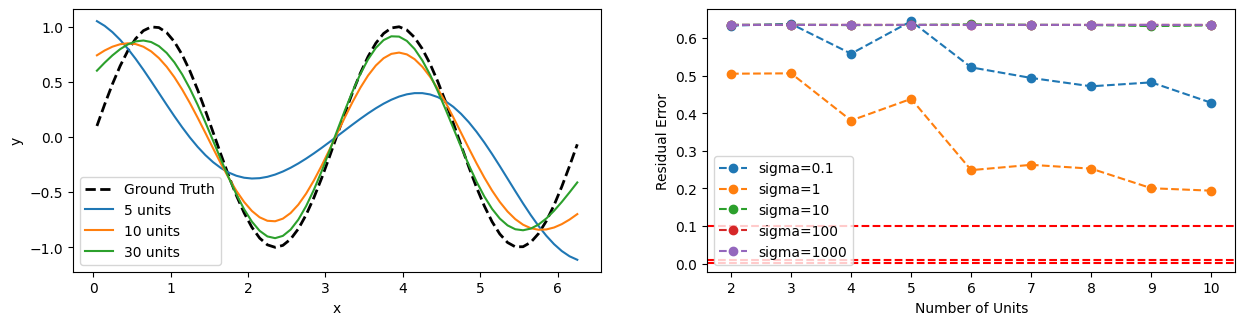

In [10]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': [0.1, 1, 10, 100, 1000]},
                    kwargs_training={'training': 'delta_rule'})

#### 3.2.2. What can you say about the rate of convergence and its dependence on the learning rate, eta, for the two learning schemes?

In [12]:

def profile_convergence(x, x_test, y, y_test, kwargs_network={}, kwargs_training={}, runs=DEFAULT_RUNS):
    """Profile convergence of RBF network training with different learning rates.
    Args:
        x: Training input data
        x_test: Test input data
        y: Training target data
        y_test: Test target data
        kwargs_network: Network configuration parameters
        kwargs_training: Training configuration parameters
        runs: Number of runs for random initialization
    """
   # Extract parameters with defaults
    training = kwargs_training.pop('training', DEFAULT_TRAINING)
    node_std = kwargs_network.pop('node_std', DEFAULT_NODE_STD)
    learning_rate = kwargs_training.pop('learning_rate', DEFAULT_LEARNING_RATE_DELTA)
    epochs = kwargs_training.pop('epochs', DEFAULT_EPOCHS_DELTA)

    def _plot_random_initialization(x, lr, runs, kwargs_network, learning_curve, cmap, i):
        """Plot multiple runs with random initialization."""
        for _ in range(runs):
            model = GaussianRBFNetwork(data=x, **kwargs_network)
            plt.plot(
                range(1, epochs+1),
                learning_curve(model, lr),
                color=cmap(i),
                alpha=0.3,
                linewidth=5,
                label=f"eta={lr}"
            )

    def _plot_single_initialization(x, lr, kwargs_network, learning_curve):
        """Plot single run with fixed initialization."""
        model = GaussianRBFNetwork(data=x, **kwargs_network)
        plt.plot(
            range(1, epochs+1),
            learning_curve(model, lr),
            label=f"eta={lr}"
        )

    def learning_curve(model, learning_rate):
        """Compute learning curve for given model and learning rate."""
        residuals = []
        for _ in range(epochs):
            model.delta_rule_train(
                x, y,
                learning_rate=learning_rate,
                epochs=1,
                improve=True,
                **kwargs_training
            )
            predictions = model.predict(x_test)
            mae = np.mean(np.abs(predictions - y_test.reshape(y_test.shape[0], 1)))
            residuals.append(mae)
        return residuals

    # Plot learning curves
    cmap = plt.get_cmap('tab10')
    is_random = kwargs_network.get('node_pos') == 'random'
    
    for i, lr in enumerate(learning_rate):
        if is_random:
            _plot_random_initialization(x, lr, runs, kwargs_network, learning_curve, cmap, i)
        else:
            _plot_single_initialization(x, lr, kwargs_network, learning_curve)

    # Add threshold lines
    for threshold in [0.1, 0.01, 0.001]:
        plt.axhline(threshold, color='r', linestyle='--')
    
    plt.xlabel("Epoch")
    plt.ylabel("Residual Error")
    plt.legend()


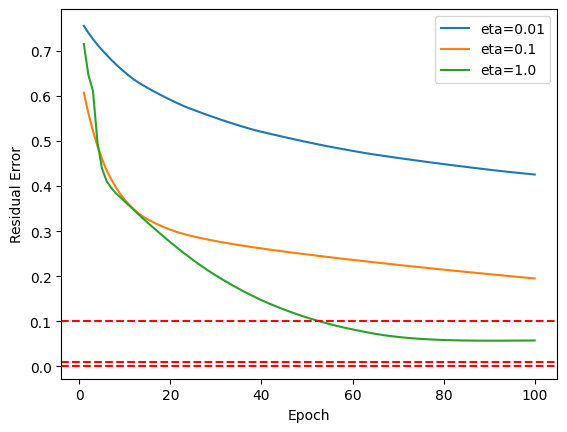

In [13]:
profile_convergence(x, x_test, y_sin, y_sin_test,
                    kwargs_training={'learning_rate': np.logspace(-2, 0, 3)})

#### 3.2.3. What are the main effets of changing the width of RBFs?

In [36]:
def profile_rbf_widths(x, x_test, y, y_test, sigma_values=None, training_params=None):
    """Profile RBF network performance with different width (sigma) values.
    
    Args:
        x: Training input data
        x_test: Test input data
        y: Training target data
        y_test: Test target data
        sigma_values: List of sigma values to test (default: [1.0])
        training_params: Additional training parameters (default: None)
    """
    # Set defaults
    sigma_values = sigma_values or [1.0]
    training_params = training_params or {}
    
    # Create figure with consistent size
    plt.figure(figsize=(10, 6))
    
    # Plot ground truth with distinct style
    plt.plot(x_test, y_test, 'k--', linewidth=2, label="Ground Truth")

    # Use a color cycle for different sigma values
    colors = plt.cm.viridis(np.linspace(0, 1, len(sigma_values)))
    
    # Train and plot for each sigma value
    for sigma, color in zip(sigma_values, colors):
        model = GaussianRBFNetwork(data=x, node_std=sigma)
        model.least_squares_fit(x, y)
        predictions = model.predict(x_test)
        plt.plot(x_test, predictions, color=color, label=f"σ={sigma:.1f}")

    # Configure plot
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("RBF Network Performance with Different Widths")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


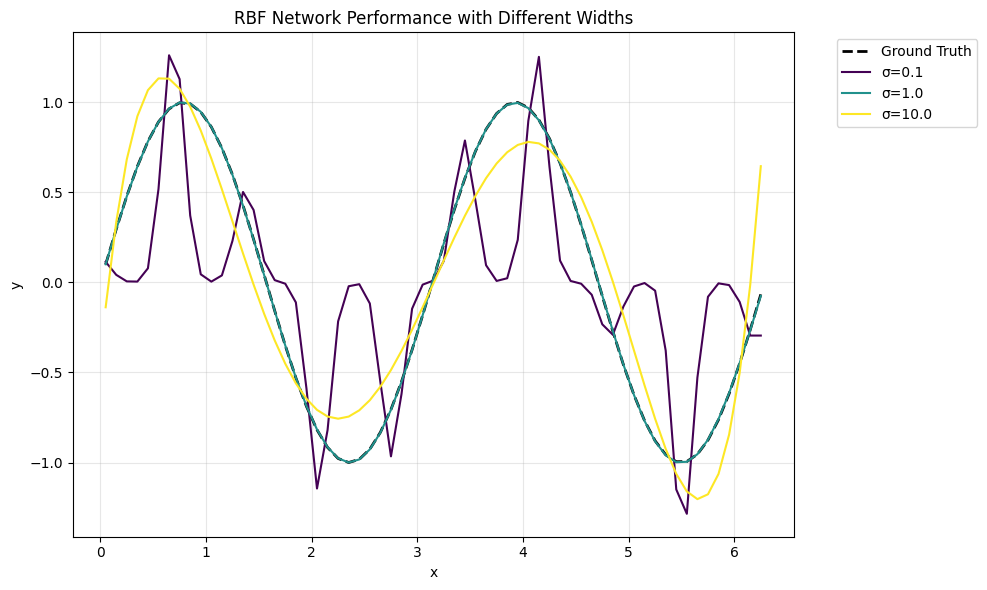

In [15]:
sigma_values = [0.1, 1, 10]
profile_rbf_widths(x, x_test, y_sin, y_sin_test, sigma_values=sigma_values)

#### 3.2.4. How important is the positioning of the RBF nodes in the input space? What strategy did you choose? Is it better than random positioning of the RBF nodes?

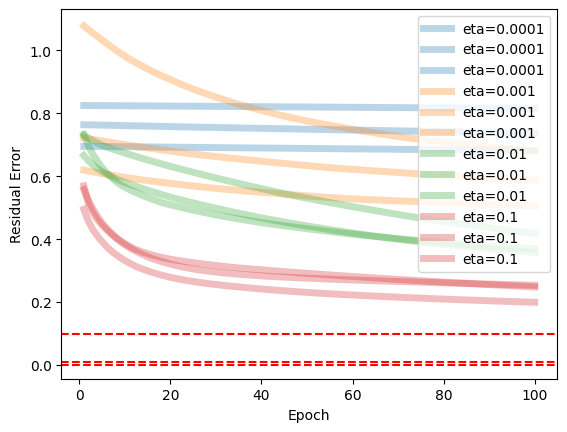

In [16]:
profile_convergence(x, x_test, y_sin, y_sin_test, kwargs_network={'node_pos': 'random'},
                    kwargs_training={'learning_rate': np.logspace(-4, -1, 4)}, runs=3)

#### 3.2.5. Also, for the same network models estimate their test performance on the original clean data used in section 3.1 (a corresponding test subset but without noise) and compare your findings.

In [17]:
def profile_clean_performance(x, y_noisy, x_test, y_test, nodes_preview, kwargs_network={}, 
                            kwargs_training={}):
    """Compare performance of RBF networks trained on noisy data and tested on clean data.
    
    Args:
        x (ndarray): Training input data
        y_noisy (ndarray): Noisy training target data
        x_test (ndarray): Test input data
        y_test (ndarray): Clean test target data
        nodes_preview (list): List of node counts to evaluate
        kwargs_network (dict): Additional network configuration parameters
        kwargs_training (dict): Additional training parameters
    """
    def fit_model(nodes, training_type):
        """Create and train a RBF network model.
        
        Args:
            nodes (int): Number of RBF nodes
            training_type (str): Training method to use
        """
        # Create model with network parameters
        model = GaussianRBFNetwork(data=x, nodes=nodes, **kwargs_network)
        
        if training_type == 'least_squares':
            model.least_squares_fit(x, y_noisy)
        else:  # delta_rule
            model.delta_rule_train(x, y_noisy, **kwargs_training)
        
        return model

    def plot_predictions(ax, training_type):
        """Plot model predictions against ground truth.
        
        Args:
            ax (Axes): Matplotlib axes object
            training_type (str): Training method to use
        """
        ax.plot(x_test, y_test, color='black', linewidth=2, 
                linestyle='--', label="Ground Truth")
        
        for nodes in nodes_preview:
            model = fit_model(nodes, training_type)
            predictions = model.predict(x_test)
            ax.plot(x_test, predictions, label=f"{nodes} units")
            
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()
        ax.set_title(f"{training_type.replace('_', ' ').title()} trained on noisy")

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.5))
    
    # Plot results for both training methods
    plot_predictions(ax1, 'least_squares')
    plot_predictions(ax2, 'delta_rule')
    
    plt.tight_layout()
    return fig

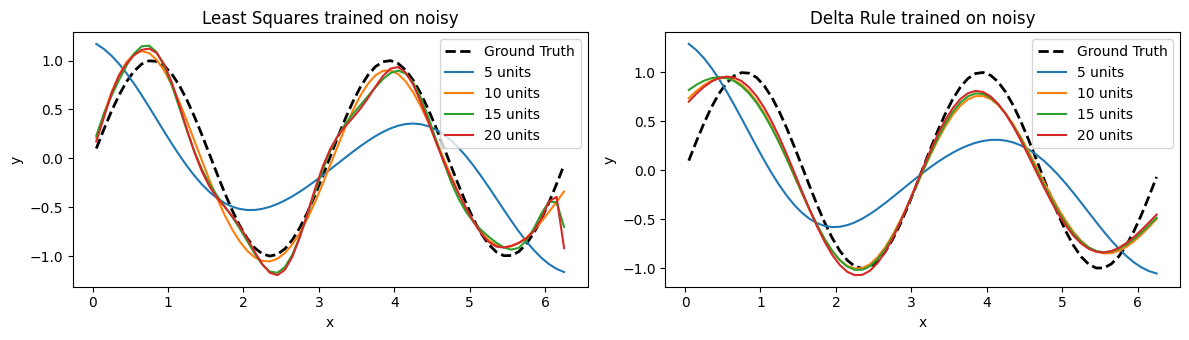

In [18]:
nodes_to_test = [5, 10, 15, 20]  # Different network sizes to evaluate
network_config = {
    'node_std': 1.0  # RBF width parameter
}
training_config = {
    'learning_rate': 0.2,  # Learning rate for delta rule
    'epochs': 100  # Number of training epochs
}

# Plot performance comparison
fig = profile_clean_performance(
    x=x,
    y_noisy=y_noisy_sin, 
    x_test=x_test,
    y_test=y_sin_test,
    nodes_preview=nodes_to_test,
    kwargs_network=network_config,
    kwargs_training=training_config
)

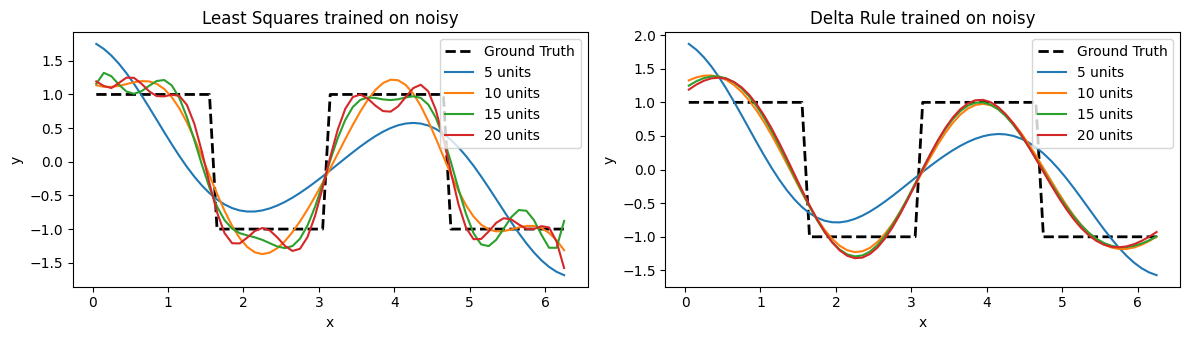

In [19]:
# Plot performance comparison
fig = profile_clean_performance(
    x=x,
    y_noisy=y_noisy_square, 
    x_test=x_test,
    y_test=y_square_test,
    nodes_preview=nodes_to_test,
    kwargs_network=network_config,
    kwargs_training=training_config
)

### 3.3. Competitive learning (CL) to initialise RBF units

#### 3.3.1  Compare the CL-based approach with your earlier RBF network where you manually positioned RBF nodes in the input space.

In [85]:
best_number_of_nodes = 6
x = np.arange(0, 2*np.pi, 0.1)[:, np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:, np.newaxis]

# Generate input data for clean sin(2x)
y_sin, _ = functions(x)
y_sin_test, _ = functions(x_test)

# Generate input data for noisy sin(2x)
y_noisy_sin, _ = functions(x, noise_variance=1)
y_test_noisy_sin, _ = functions(x_test, noise_variance=1)

clean_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='equal')
clean_rbf.delta_rule_train(x, y_sin, epochs=800)
random_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='random')
random_rbf.delta_rule_train(x, y_sin, epochs=800)
noisy_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='equal')
noisy_rbf.delta_rule_train(x, y_noisy_sin, epochs=800)

cl_clean_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='cl', cl_epochs=100)
cl_clean_rbf.delta_rule_train(x, y_sin, epochs=800)
cl_noisy_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='cl', cl_epochs=100)
cl_noisy_rbf.delta_rule_train(x, y_noisy_sin, epochs=800)

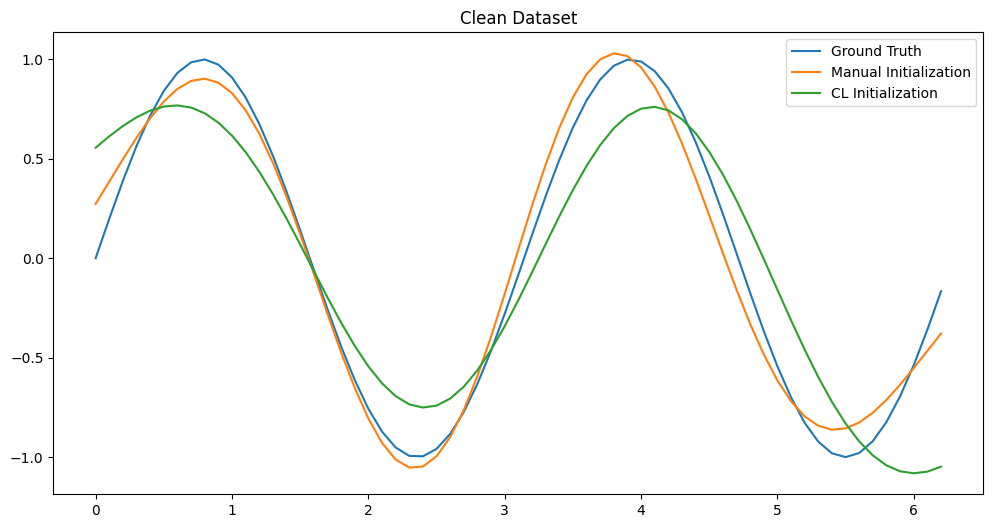

In [ ]:
y_pred_random = random_rbf.predict(x_test)
y_pred_clean = clean_rbf.predict(x_test)
y_pred_noisy = noisy_rbf.predict(x_test)
y_pred_cl_clean = cl_clean_rbf.predict(x_test)
y_pred_cl_noisy = cl_noisy_rbf.predict(x_test)

plt.figure(figsize=(12, 6))
plt.plot(x, y_sin, label='Ground Truth')
plt.plot(x, y_pred_clean, label='Manual Initialization')
# plt.plot(x, y_pred_random, label='Random Initialization')
plt.plot(x, y_pred_cl_clean, label='CL Initialization')
plt.title('Clean Dataset')
plt.legend()
plt.show()

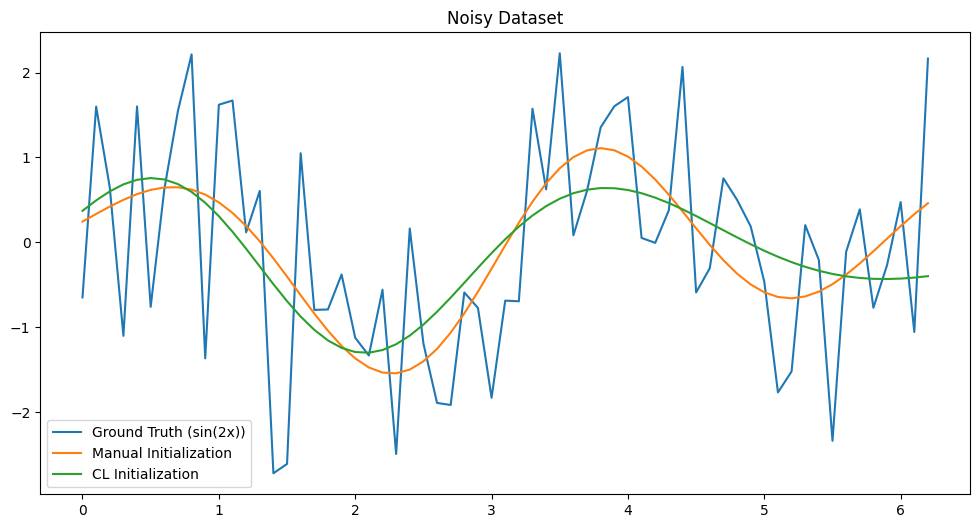

In [90]:
plt.figure(figsize=(12, 6))
plt.plot(x, y_noisy_sin, label='Ground Truth (sin(2x))')
plt.plot(x, y_pred_noisy, label='Manual Initialization')
plt.plot(x, y_pred_cl_noisy, label='CL Initialization')
plt.title('Noisy Dataset')
plt.legend()
plt.show()


In [95]:
from sklearn.metrics import mean_absolute_error

def calculate_residuals(y_sin_test, y_pred):
    return y_sin_test - y_pred

maes = {
    "Clean": mean_absolute_error(y_sin_test, y_pred_clean),
    "CL Clean": mean_absolute_error(y_sin_test, y_pred_cl_clean),
}

print("Mean Absolute Errors (MAE) for Each Prediction Set:\n")
for label, mae in maes.items():
    print(f"{label}: {mae:.4f}")

Mean Absolute Errors (MAE) for Each Prediction Set:

Clean: 0.0703
CL Clean: 0.2597


#### 3.3.2 Introduce a strategy to avoid dead units, e.g. by having more than a single winner. Choose an example to demonstrate this effect in comparison with the vanilla version of our simple CL algorithm.

In [99]:
neighbourhood_cl_clean_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='cl_prevent_dead_units', cl_epochs=100)
neighbourhood_cl_clean_rbf.delta_rule_train(x, y_sin, epochs=800)
neighbourhood_cl_noisy_rbf = GaussianRBFNetwork(data=x, nodes=best_number_of_nodes, node_pos='cl_prevent_dead_units', cl_epochs=100)
neighbourhood_cl_noisy_rbf.delta_rule_train(x, y_noisy_sin, epochs=800)

neighbourhood_y_pred_cl_clean = neighbourhood_cl_clean_rbf.predict(x_test)
neighbourhood_y_pred_cl_noisy = neighbourhood_cl_noisy_rbf.predict(x_test)

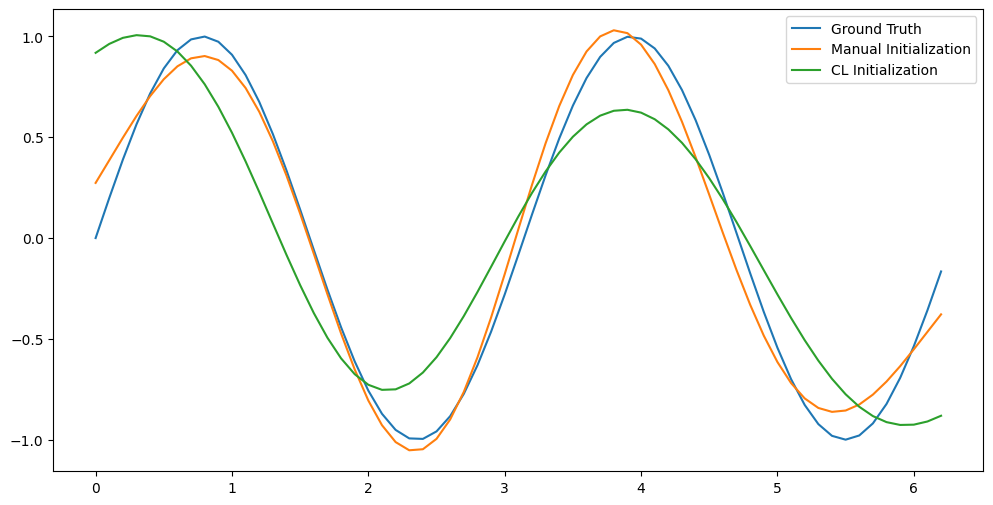

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(x, y_sin, label='Ground Truth')
plt.plot(x, y_pred_clean, label='Manual Initialization')
plt.plot(x, neighbourhood_y_pred_cl_clean, label='CL Initialization')
plt.legend()
plt.show()

In [98]:
maes = {
    "Clean Manual": mean_absolute_error(y_sin_test, y_pred_clean),
    "Clean Neighbourhood CL": mean_absolute_error(y_sin_test, neighbourhood_y_pred_cl_clean),
    "Noisy Manual": mean_absolute_error(y_sin_test, y_pred_noisy),
    "Noisy Neighbourhood CL": mean_absolute_error(y_sin_test, neighbourhood_y_pred_cl_noisy),
}

print("Mean Absolute Errors (MAE) for Each Prediction Set:\n")
for label, mae in maes.items():
    print(f"{label}: {mae:.4f}")

Mean Absolute Errors (MAE) for Each Prediction Set:

Clean Manual: 0.0703
Clean Neighbourhood CL: 0.1951
Noisy Manual: 0.3029
Noisy Neighbourhood CL: 0.2881


#### 3.2.3 RBF Network with CL for 2-Dimensional Modelling

In [108]:
import pandas as pd

df_ballist = pd.read_csv('data\\ballist.dat', sep='\s+', header=None)
df_balltest = pd.read_csv('data\\balltest.dat', sep='\s+', header=None)
df_ballist.columns = ['angle', 'velocity', 'distance', 'height']
df_balltest.columns = ['angle', 'velocity', 'distance', 'height']
print(df_ballist)

    angle  velocity  distance  height
0   0.896     0.540     0.093   0.260
1   0.279     0.859     0.566   0.122
2   0.307     0.403     0.133   0.032
3   0.974     0.546     0.024   0.273
4   0.069     0.903     0.175   0.009
..    ...       ...       ...     ...
95  0.445     0.263     0.068   0.026
96  0.651     0.896     0.714   0.536
97  0.917     0.023     0.000   0.000
98  0.776     0.135     0.012   0.015
99  0.844     0.925     0.403   0.738

[100 rows x 4 columns]


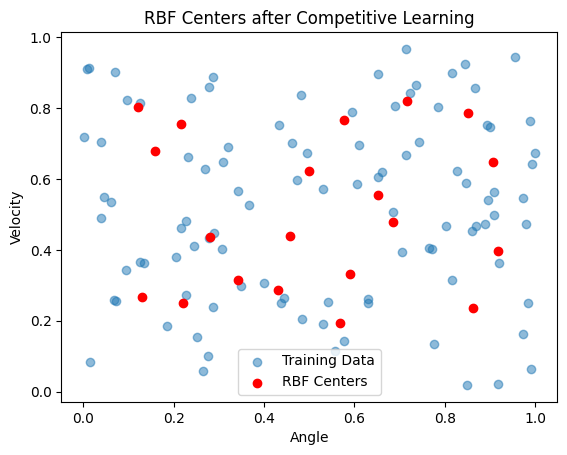

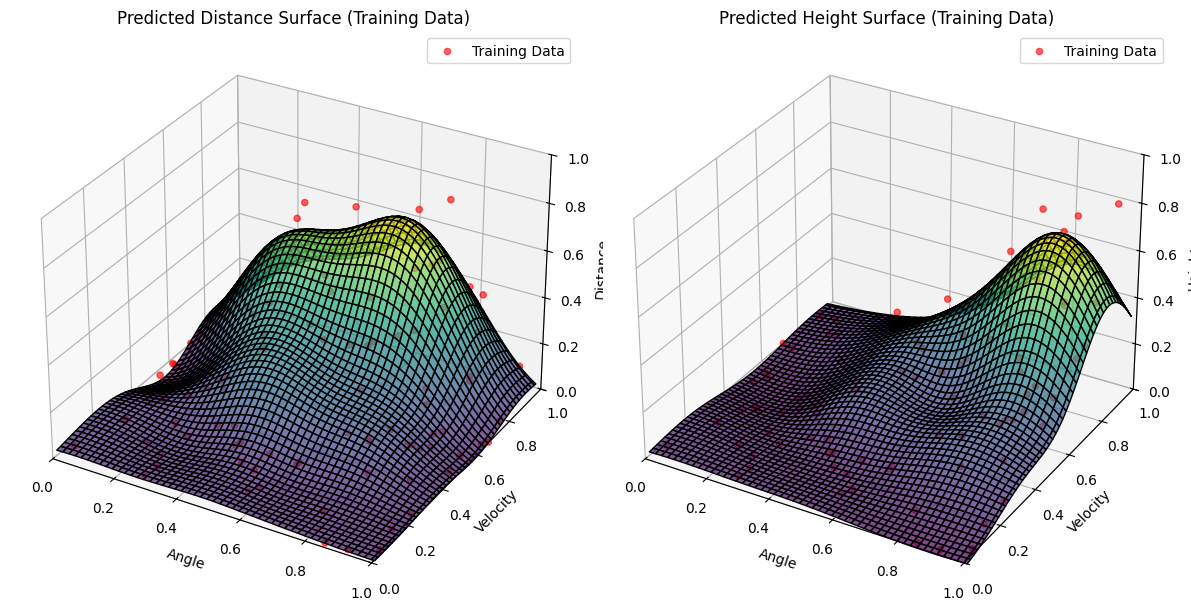

Train MSE: 0.0030
Test MSE: 0.0069


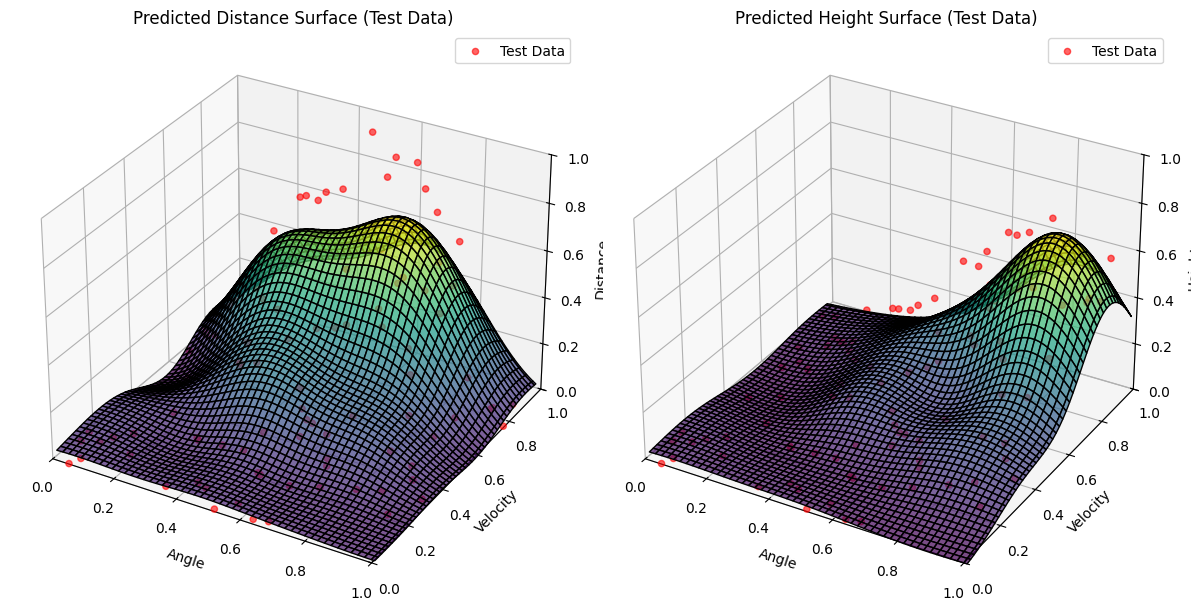

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error

# Load data
df_ballist = pd.read_csv('data\\ballist.dat', sep='\s+', header=None)
df_ballist.columns = ['angle', 'velocity', 'distance', 'height']
X_train = df_ballist[['angle', 'velocity']].values
Y_train = df_ballist[['distance', 'height']].values

# Competitive Learning Algorithm
def competitive_learning(X, num_units, num_iterations, initial_lr=0.1, initial_neighborhood=2):
    np.random.seed(0)
    centers = X[np.random.choice(X.shape[0], num_units, replace=False)]  # Initialize centers randomly
    lr = initial_lr
    neighborhood_size = initial_neighborhood

    for t in range(num_iterations):
        # Select a random input vector
        x = X[np.random.choice(X.shape[0])]

        # Find the winner unit (closest center)
        distances = np.linalg.norm(centers - x, axis=1)
        winner_idx = np.argmin(distances)

        # Update the winner and its neighbors
        for i in range(num_units):
            distance_to_winner = abs(i - winner_idx)
            if distance_to_winner <= neighborhood_size:
                # Compute the neighborhood influence (Gaussian decay)
                influence = np.exp(-distance_to_winner**2 / (2 * neighborhood_size**2))
                centers[i] += lr * influence * (x - centers[i])

        # Decay learning rate and neighborhood size over time
        lr = initial_lr * np.exp(-t / num_iterations)
        neighborhood_size = max(1, initial_neighborhood * np.exp(-t / (num_iterations / 4)))

    return centers

# Apply Competitive Learning
num_units = 20  # Number of RBF units
num_iterations = 1000
centers = competitive_learning(X_train, num_units, num_iterations)

# Plot the resulting centers in input space
plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], color='red', label='RBF Centers')
plt.title('RBF Centers after Competitive Learning')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.legend()
plt.show()

# Compute the spread (beta) for each RBF unit based on average distance to k-nearest neighbors
def compute_beta(centers, k=3):
    """Compute beta (spread parameter) for each center based on average distance to k-nearest neighbors."""
    dists = cdist(centers, centers)
    np.fill_diagonal(dists, np.inf)  # Ignore self-distances
    nearest_dists = np.sort(dists, axis=1)[:, :k]
    avg_dist = np.mean(nearest_dists, axis=1)
    beta = 1 / (2 * (avg_dist**2))  # Gaussian RBF width
    return beta

beta_values = compute_beta(centers)

# RBF Network with Competitive Learning Centers
class RBFNetworkCL:
    def __init__(self, centers, beta_values):
        self.centers = centers
        self.beta = beta_values
        self.weights = None

    def _rbf(self, X, center, beta):
        return np.exp(-beta * np.linalg.norm(X - center, axis=1)**2)

    def fit(self, X, Y):
        G = np.zeros((X.shape[0], len(self.centers)))
        for i, (center, beta) in enumerate(zip(self.centers, self.beta)):
            G[:, i] = self._rbf(X, center, beta)

        # Compute weights using pseudo-inverse
        self.weights = np.linalg.pinv(G).dot(Y)

    def predict(self, X):
        G = np.zeros((X.shape[0], len(self.centers)))
        for i, (center, beta) in enumerate(zip(self.centers, self.beta)):
            G[:, i] = self._rbf(X, center, beta)
        return G.dot(self.weights)

# Train the RBF Network
rbf_net = RBFNetworkCL(centers, beta_values)
rbf_net.fit(X_train, Y_train)

# Generate a mesh grid to plot the prediction surface
angle_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
velocity_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
angle_grid, velocity_grid = np.meshgrid(angle_range, velocity_range)
input_grid = np.vstack([angle_grid.ravel(), velocity_grid.ravel()]).T

# Predict the corresponding distance and height values
Y_pred_grid = rbf_net.predict(input_grid)
distance_grid = Y_pred_grid[:, 0].reshape(angle_grid.shape)
height_grid = Y_pred_grid[:, 1].reshape(velocity_grid.shape)

# Plot the prediction surface for the training data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(angle_grid, velocity_grid, distance_grid, cmap='viridis', edgecolor='k', alpha=0.7)
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 0], color='r', label='Training Data', alpha=0.6)
ax.set_title('Predicted Distance Surface (Training Data)')
ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Distance')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.legend()

# Plot the height surface for the training data
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(angle_grid, velocity_grid, height_grid, cmap='viridis', edgecolor='k', alpha=0.7)
ax2.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 1], color='r', label='Training Data', alpha=0.6)
ax2.set_title('Predicted Height Surface (Training Data)')
ax2.set_xlabel('Angle')
ax2.set_ylabel('Velocity')
ax2.set_zlabel('Height')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_zlim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

# Test the model
df_balltest = pd.read_csv('data\\balltest.dat', sep='\s+', header=None)
df_balltest.columns = ['angle', 'velocity', 'distance', 'height']
X_test = df_balltest[['angle', 'velocity']].values
Y_test = df_balltest[['distance', 'height']].values

# Predict on test data
Y_pred_test = rbf_net.predict(X_test)
Y_pred_train = rbf_net.predict(X_train)

# Calculate test error
train_mse = mean_squared_error(Y_train, Y_pred_train)
test_mse = mean_squared_error(Y_test, Y_pred_test)
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Generate prediction surface for the test set
Y_pred_test_grid = rbf_net.predict(input_grid)
distance_test_grid = Y_pred_test_grid[:, 0].reshape(angle_grid.shape)
height_test_grid = Y_pred_test_grid[:, 1].reshape(velocity_grid.shape)

# Plot the prediction surface for the test data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(angle_grid, velocity_grid, distance_test_grid, cmap='viridis', edgecolor='k', alpha=0.7)
ax.scatter(X_test[:, 0], X_test[:, 1], Y_test[:, 0], color='r', label='Test Data', alpha=0.6)
ax.set_title('Predicted Distance Surface (Test Data)')
ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Distance')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.legend()

# Plot the height surface for the test data
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(angle_grid, velocity_grid, height_test_grid, cmap='viridis', edgecolor='k', alpha=0.7)
ax2.scatter(X_test[:, 0], X_test[:, 1], Y_test[:, 1], color='r', label='Test Data', alpha=0.6)
ax2.set_title('Predicted Height Surface (Test Data)')
ax2.set_xlabel('Angle')
ax2.set_ylabel('Velocity')
ax2.set_zlabel('Height')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_zlim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()
